#### About Dataset
##### goodbooks-10k
This dataset contains six million ratings for ten thousand most popular (with most ratings) books. There are also:
##### Contents
- ratings.csv contains user ratings for each book. It is 69MB.
- books.csv has metadata for each book (goodreads IDs, authors, title, average rating, etc.).

##### Importing relevant libraries and setting display options

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Adjust the display width to show all data
pd.set_option('display.max_rows', None)     # Show all rows (not limited to 10)

##### Loading Datasets

In [52]:
books_df = pd.read_csv('books.csv')
ratings_df = pd.read_csv('ratings.csv')

#### Data Cleaning - Cleaning Books.csv file

##### Checking for missing data

In [53]:
# Checking percentage of missing data
print(round((books_df.isnull().sum()/books_df.shape[0])*100,2))

book_id                       0.00
goodreads_book_id             0.00
best_book_id                  0.00
work_id                       0.00
books_count                   0.00
isbn                          7.00
isbn13                        5.85
authors                       0.00
original_publication_year     0.21
original_title                5.85
title                         0.00
language_code                10.84
average_rating                0.00
ratings_count                 0.00
work_ratings_count            0.00
work_text_reviews_count       0.00
ratings_1                     0.00
ratings_2                     0.00
ratings_3                     0.00
ratings_4                     0.00
ratings_5                     0.00
image_url                     0.00
small_image_url               0.00
dtype: float64


##### Analysis

isbn has 7% missing data.
isbn13 has 5.85% missing data.
0.21% original publication year data are missing.
5.85% original title data are missing.
10.84% language code data are missing.
None of the remaining columns has missing data.

What do we do to the columns having missing data? 
This depends on whether or not we will be needing the columns in our exploratory analysis and model development.
We wont be needing the two isbn columns in either of exploratory analysis and model development. We will therefore be dropping the two columns from the dataset.
We will be needing the rest of the columns containing missing data in our exploratory analysis but none of them will be used in the model development.
Since missing data would impact our exploratory analysis, what do we do about them?
Deleting rows with missing data will enrich our exploratory analysis but deny us of data for model training.
Denying our model of 1000+ rows of data is not an advisable thing.
We therefore cannot go with the option of deleting rows.
We will fill missing original title and language code data with unknown. Then if an exploratory analysis depends on either of the two columns, we will exclude rows containing the two columns from the analysis.
We will leave missing original publication year as NaN.

In [54]:
# Filling missing values in both 'language code' and 'original title' columns with 'Unknown'
books_df[['language_code', 'original_title']] = books_df[['language_code', 'original_title']].fillna('Unknown')
# Check if there are any remaining missing values in the 'language code' and 'original title' columns
missing_values = books_df[['language_code', 'original_title']].isnull().sum()
print(missing_values)

language_code     0
original_title    0
dtype: int64


##### Analysis

We no longer have missing language code and original title data.

##### Removing white spaces and new line characters, converting to lowercase

We will be removing white spaces and new line characeters from the categorical columns in the data set. We will also convert each text in the columns to lowercase.
Categorical columns are text columns different from numerical columns which contain numbers.

In [55]:
# Identify and print Categorical columns in the dataframe
cat_col = [col for col in books_df.columns if books_df[col].dtype == 'object'] 
print('Categorical columns :',cat_col) 
# Create a dictionary to specify transformations - removing whitespace and accidental newline characters, converting to lowercase - for each column
transformations = {
    col: books_df[col].str.replace('\n', '').str.lstrip().str.lower() if col in cat_col else books_df[col]
    for col in books_df.columns
}

# Update the DataFrame with transformations
books_df = books_df.assign(**transformations)

Categorical columns : ['isbn', 'authors', 'original_title', 'title', 'language_code', 'image_url', 'small_image_url']


##### Unique and Duplicate Data

What proportion of our categorical data is unique, what proportion contains duplicates? We will find out in the next few sections.

In [56]:
# Identify and print number of unique data and total data excluding 'Unknown' in each categorical column
unique_counts_excluding_unknown = books_df[cat_col].apply(lambda x: x[x != 'Unknown'].nunique())
total_counts_excluding_unknown = books_df[cat_col].apply(lambda x: x[x != 'Unknown'].count())


# Combine the results into a DataFrame
summary_df = pd.DataFrame({
    'Column': unique_counts_excluding_unknown.index,
    'Total Unique Data': unique_counts_excluding_unknown.values,
    'Total Data': total_counts_excluding_unknown.values
})

print(summary_df.to_string(index=False))


         Column  Total Unique Data  Total Data
           isbn               9300        9300
        authors               4664       10000
 original_title               9274       10000
          title               9964       10000
  language_code                 26       10000
      image_url               6669       10000
small_image_url               6669       10000


##### Analysis

Of the 9300 isbns in the dataset, 9300 are unique which means there are no repeating isbns. 
Of the 10000 authors in the authors column, only 4664 are unique. That's expected since some authors will have more than one titles associated with them. 
Of the 9415 original titles in the original_title column, only 9275 are unique. There are repeating original titles. 
Of the 10000 titles in the title column, only 9964 are unique. There are repeating titles. 
Of the 8916 language codes in the language_code column, only 26 are unique. This means there are only 26 language codes shared accross the books. 
Of the 10000 image urls in the image_url column, only 6669 are unique. Does this mean dissimilar titles are sharing the same image urls? 

###### Exploring title column

Lets further investigate uniqueness by exploring the title column.

In [57]:
# Identify and print the first ten unique titles in the title column
print(books_df['title'].unique()[:10])

['the hunger games (the hunger games, #1)'
 "harry potter and the sorcerer's stone (harry potter, #1)"
 'twilight (twilight, #1)' 'to kill a mockingbird' 'the great gatsby'
 'the fault in our stars' 'the hobbit' 'the catcher in the rye'
 'angels & demons  (robert langdon, #1)' 'pride and prejudice']


In [9]:
# Find duplicate titles
duplicate_titles = books_df[books_df.duplicated(subset=['title'], keep=False)]

# Print the first 10 duplicates
display(duplicate_titles.head(10).reset_index(drop=True))

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,129,332613,332613,2100252,275,451163966,9.780451e+12,ken kesey,1962.0,one flew over the cuckoo's nest,one flew over the cuckoo's nest,eng,4.18,491642,514458,7855,5672,15978,78714,191622,222472,https://images.gr-assets.com/books/1485308778m...,https://images.gr-assets.com/books/1485308778s...
1,162,49552,49552,3324344,675,NaN,NaN,"albert camus, matthew ward",1942.0,l’étranger,the stranger,eng,3.96,420600,483623,14836,10563,28920,100140,174957,169043,https://images.gr-assets.com/books/1349927872m...,https://images.gr-assets.com/books/1349927872s...
2,331,10916,10916,3349846,76,61150142,9.780061e+12,jodi picoult,1998.0,the pact,the pact,en-us,4.00,221225,235359,9257,3586,11789,50494,85430,84060,https://images.gr-assets.com/books/1410754561m...,https://images.gr-assets.com/books/1410754561s...
3,349,11590,11590,3048937,211,450031063,9.780450e+12,stephen king,1975.0,salem's lot,'salem's lot,en-gb,3.99,228680,246360,6167,2713,11724,57171,89196,85556,https://images.gr-assets.com/books/1327891565m...,https://images.gr-assets.com/books/1327891565s...
4,512,23919,23919,30431,34,385074077,9.780385e+12,edgar allan poe,1849.0,the complete tales of edgar allan poe,the complete stories and poems,en-us,4.37,160063,160326,1055,1247,2923,19028,49902,87226,https://images.gr-assets.com/books/1327942676m...,https://images.gr-assets.com/books/1327942676s...
5,579,197084,197084,1837885,44,1713221,9.780002e+12,p.d. eastman,1960.0,are you my mother?,are you my mother?,eng,4.16,174204,177809,1864,3986,8065,31523,45916,88319,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6,1174,26893819,26893819,42856015,59,081299860x,9.780813e+12,emma cline,2016.0,the girls,the girls,eng,3.49,76761,94812,11573,2905,11033,32122,34599,14153,https://images.gr-assets.com/books/1492065338m...,https://images.gr-assets.com/books/1492065338s...
7,1260,7510,7510,22576,60,446612545,9.780447e+12,"james patterson, peter de jonge",2002.0,the beach house,the beach house,eng,3.82,68676,70371,1628,1125,4351,20127,25271,19497,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8,1292,5413,5413,40802405,22,385516487,9.780386e+12,"stephen king, jerry n. uelsmann",2005.0,'salem's lot the illustrated edition,'salem's lot,eng,4.25,72797,74725,482,460,1854,12040,24920,35451,https://images.gr-assets.com/books/1320478491m...,https://images.gr-assets.com/books/1320478491s...
9,1996,180617,180617,2685281,1032,140382623,9.780140e+12,"carlo collodi, john boyne, monteiro lobato, un...",1883.0,le avventure di pinocchio,pinocchio,eng,3.86,48961,55985,1405,1235,4063,14916,17113,18658,https://images.gr-assets.com/books/1327938097m...,https://images.gr-assets.com/books/1327938097s...


###### Analysis

Because One Flew Over the Cuckoo's Nest appears in the result, it means the title appears more than once in the title column, but why is this the case? In the next sections, we will find out.

In [10]:
# Determining why One Flew Over the Cuckoo's Nest appears more than once
# Define the title you want to search for
search_title = "one flew over the cuckoo's nest"

# Use boolean indexing to filter rows with the specified title
rows_with_title = books_df[books_df['title'] == search_title]

# Print the filtered rows
display(rows_with_title.reset_index(drop=True))

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,129,332613,332613,2100252,275,451163966,9.780451e+12,ken kesey,1962.0,one flew over the cuckoo's nest,one flew over the cuckoo's nest,eng,4.18,491642,514458,7855,5672,15978,78714,191622,222472,https://images.gr-assets.com/books/1485308778m...,https://images.gr-assets.com/books/1485308778s...
1,9297,827497,827497,813221,3,573613435,9.780574e+12,dale wasserman,1970.0,one flew over the cuckoo's nest (script),one flew over the cuckoo's nest,unknown,4.28,11142,11181,90,106,253,1432,3961,5429,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


##### Analysis
We did a search for the rows containing the title. Going over the data revealed that while two books share the same title, one is an adaptation of the other and written by another author.

##### Same title, same authors
Are there books with the same titles and authors? We will find out in the next sections.

In [11]:
# Finding out if there are books with same titles and authors
# Group by 'title' and 'authors', then count the number of occurrences
duplicate_books = books_df.groupby(['title', 'authors']).size().reset_index(name='count')

# Filter out only those entries where count > 1, indicating duplicates
duplicate_books = duplicate_books[duplicate_books['count'] > 1]

# Print the duplicate books
print("Duplicate Books:")
print(duplicate_books)

Duplicate Books:
Empty DataFrame
Columns: [title, authors, count]
Index: []


##### Analysis
An empty dataframe was returned which implies No.

##### Handling outliers

Outliers are data that are beyond the expected or ordinary. They fall outside valid ranges.
Lets check for outliers in the original_publication_year column.

In [12]:
# Checking if dataset contains outlier years
# Define the list of years to check for
years_to_check = [0, 2024, 2026, 2030, 2037, 2038, 2050]

# Check if any of these years exist in the 'original_publication_year' column
rows_with_specific_years = books_df[books_df['original_publication_year'].isin(years_to_check)]

# Print the filtered rows
print(rows_with_specific_years)

Empty DataFrame
Columns: [book_id, goodreads_book_id, best_book_id, work_id, books_count, isbn, isbn13, authors, original_publication_year, original_title, title, language_code, average_rating, ratings_count, work_ratings_count, work_text_reviews_count, ratings_1, ratings_2, ratings_3, ratings_4, ratings_5, image_url, small_image_url]
Index: []


##### Analysis

A returned empty dataframe implies none.

#### Descriptive statistics

In [13]:
books_df.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


##### Analysis
If we look at the minimum and max for each column, we will see that original_publication_year column has an outlier - negative years. How many rows have negtive years? We will find out next.

In [14]:
# Count the number of rows with negative values in 'original publication year'
negative_years_count = books_df[books_df['original_publication_year'] < 0].shape[0]

print(f"Number of rows with negative 'original publication year': {negative_years_count}")


Number of rows with negative 'original publication year': 31


##### Analysis
We have just 31 rows. We can drop these rows without worries. We do that next.

In [15]:
# Drop rows with negative years
books_df = books_df[books_df['original_publication_year'] >= 0]

In [16]:
# Count the number of rows with negative values in 'original publication year'
negative_years_count = books_df[books_df['original_publication_year'] < 0].shape[0]

print(f"Number of rows with negative 'original publication year': {negative_years_count}")


Number of rows with negative 'original publication year': 0


#### Data Cleaning - Cleaning ratings.csv file

##### Checking for missing data

In [17]:
# Checking percentage of missing data
print(round((ratings_df.isnull().sum()/ratings_df.shape[0])*100,2))

user_id    0.0
book_id    0.0
rating     0.0
dtype: float64


#### No data is missing.

#### Unique and Duplicates

In [18]:
# Identify and print number of unique data and total data
unique_counts = ratings_df.nunique()
total_counts = ratings_df.count()


# Combine the results into a DataFrame
summary_df = pd.DataFrame({
    'Column': unique_counts.index,
    'Total Unique Data': unique_counts.values,
    'Total Data': total_counts.values
})

print(summary_df.to_string(index=False))


 Column  Total Unique Data  Total Data
user_id              53424     5976479
book_id              10000     5976479
 rating                  5     5976479


##### Analysis
There are 53424 unique user ids in the data set. But there are 5976479 rows of user ids. Same users will rate different books. This explains the duplication.
There are 10000 unique book ids. This is expected since our dataset is a dataset of 10000 books. But there are 5976479 rows of book ids. This is expected since there are same rows of user ids. Each row is for a particular rating and each rating has a user id and book id attached to it.
Ratings are between 1 and 5. There are therefore 5 unique ratings. But the ratings are expectedly 5976479 in total.

#### Duplicate rows

Are there duplicate rows? Rows with the same user id, book id, and rating?

In [19]:
# Checking for duplicate data
duplicate_data = ratings_df.duplicated().sum()
print("Number of duplicate rows:")
print(duplicate_data)


Number of duplicate rows:
0


No.

##### Can multiple ratings be found for the same combination of user id and book id?

In [20]:
# Group by 'user_id' and 'book_id' and count the occurrences
duplicate_ratings = ratings_df.groupby(['user_id', 'book_id']).size().reset_index(name='count')

# Filter groups with counts greater than 1
multiple_ratings = duplicate_ratings[duplicate_ratings['count'] > 1]

# Print the result
if multiple_ratings.empty:
    print("No multiple ratings found for the same combination of user_id and book_id.")
else:
    print("Multiple ratings found for the same combination of user_id and book_id:")
    print(multiple_ratings)

No multiple ratings found for the same combination of user_id and book_id.


No.

### Exploratory Analysis

##### Exploratory Analysis - books.csv

##### Printing the first five book data

In [21]:
# Printing the books dataset
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,suzanne collins,2008.0,the hunger games,"the hunger games (the hunger games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"j.k. rowling, mary grandpré",1997.0,harry potter and the philosopher's stone,harry potter and the sorcerer's stone (harry p...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,stephenie meyer,2005.0,twilight,"twilight (twilight, #1)",en-us,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,harper lee,1960.0,to kill a mockingbird,to kill a mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,f. scott fitzgerald,1925.0,the great gatsby,the great gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


There are 10000 books. What are the best ways to explore them?
Lets start by checking the number of unique authors.

In [22]:
# Identify and print number of unique and total authors
unique_counts = books_df['authors'].nunique()
total_counts = books_df['authors'].count()

# Combine the results into a DataFrame
summary_df = pd.DataFrame({
    'Total Unique Authors': [unique_counts],
    'Total Authors': [total_counts]
})

print(summary_df.to_string(index=False))


 Total Unique Authors  Total Authors
                 4624           9948


Of 10000 rows of authors, only 4664 are unique. 4664 is a large number. We wont be able to visualize the books per authors.
But we can visualize top ten authors.

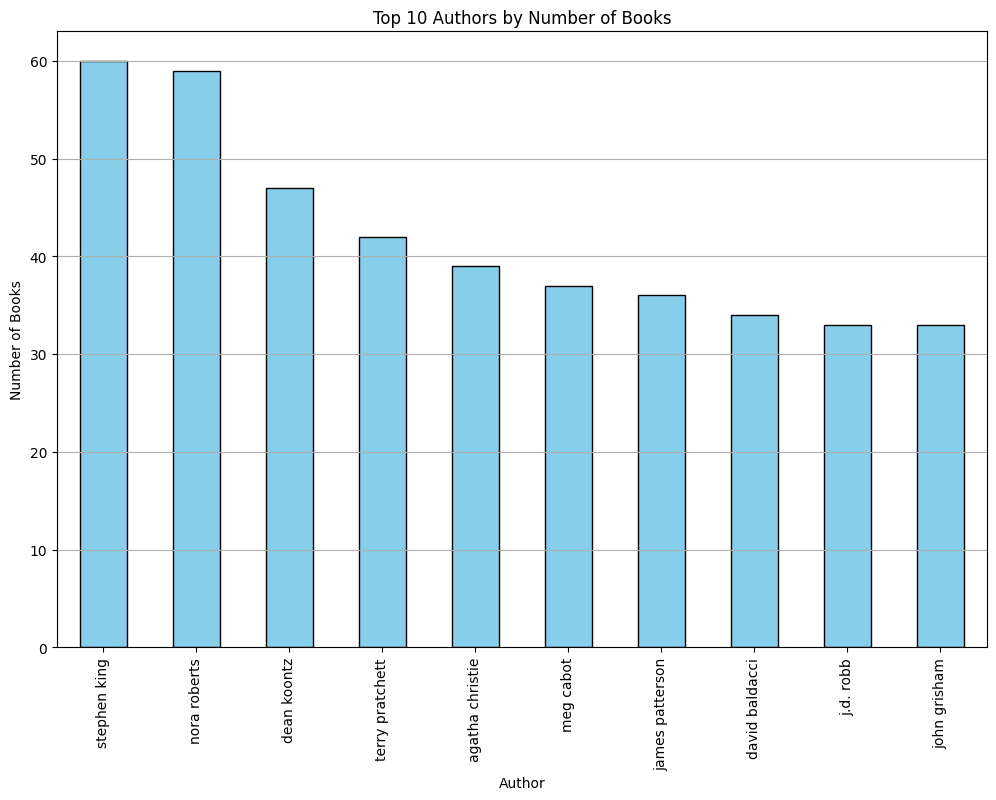

In [23]:
# Count the number of books per author
author_counts = books_df['authors'].value_counts()

# Select the top 10 authors for visualization
top_authors = author_counts.head(10)

# Plot bar chart
plt.figure(figsize=(12, 8))
top_authors.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.title('Top 10 Authors by Number of Books')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


Stephen King is the winner here.

Lets check the number of unique publication years.

In [24]:
# Identify and print number of unique and total publication years
total_counts = books_df['original_publication_year'].count()

# Combine the results into a DataFrame
summary_df = pd.DataFrame({
    'Total Unique Original Publication Year': [unique_counts],
    'Total Original Publication Year': [total_counts]
})

print(summary_df.to_string(index=False))

 Total Unique Original Publication Year  Total Original Publication Year
                                   4624                             9948


of 9979 rows, only 293 is unique. The number is manageable.

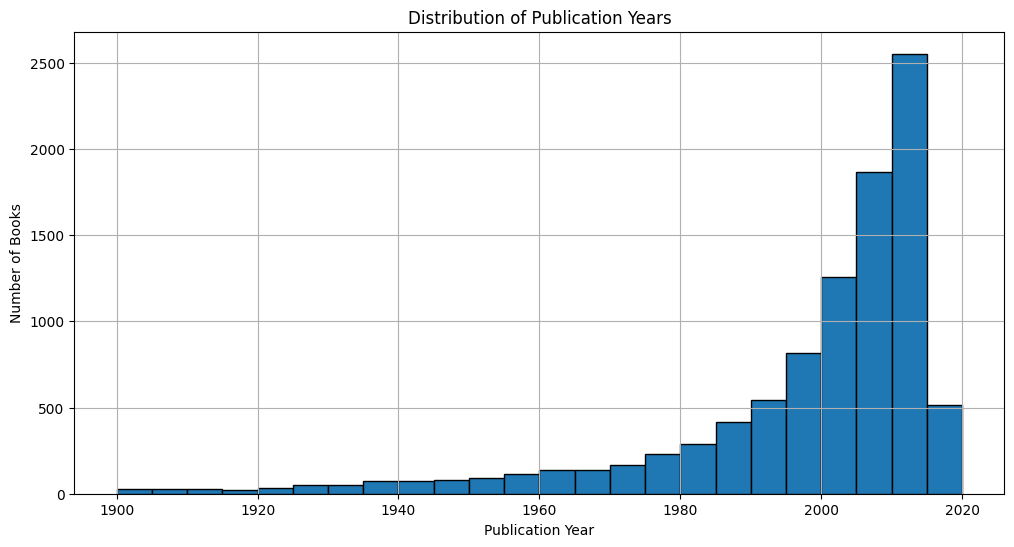

In [25]:
# Plot histogram of publication years
plt.figure(figsize=(12, 6))
plt.hist(books_df['original_publication_year'], bins=range(1900, 2025, 5), edgecolor='black')
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.title('Distribution of Publication Years')
plt.grid(True)
plt.show()


The histogram shows that majority of the books were published in the 21st century.

#### Visualizing average ratings
Each book has a particular number of people that gave it a rating between 1 and 5 which are part of the meta data. The average_rating column contains the average of these ratings. What is the frequency of a particular average rating? Which books have the top ten average rating?

#### Frequency of average rating

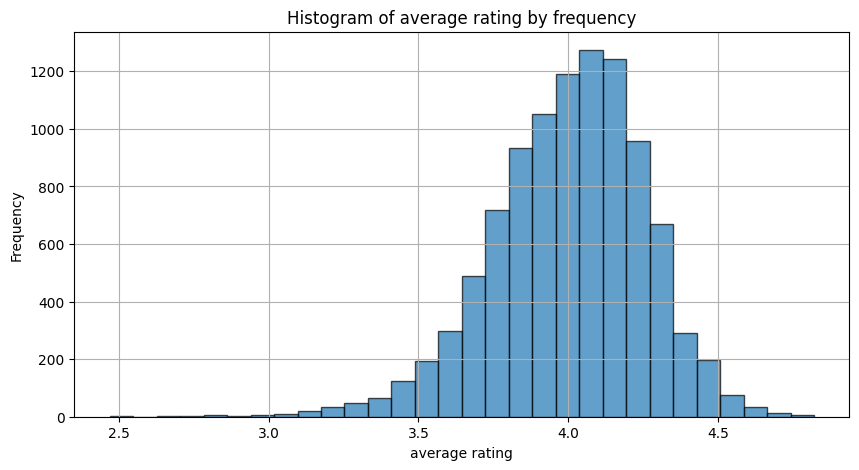

In [26]:
# Plot histogram for average_rating
plt.figure(figsize=(10, 5))
plt.hist(books_df['average_rating'].dropna(), bins=30, alpha=0.7, edgecolor='black')
plt.title(f'Histogram of average rating by frequency')
plt.xlabel('average rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### Top Books by average rating

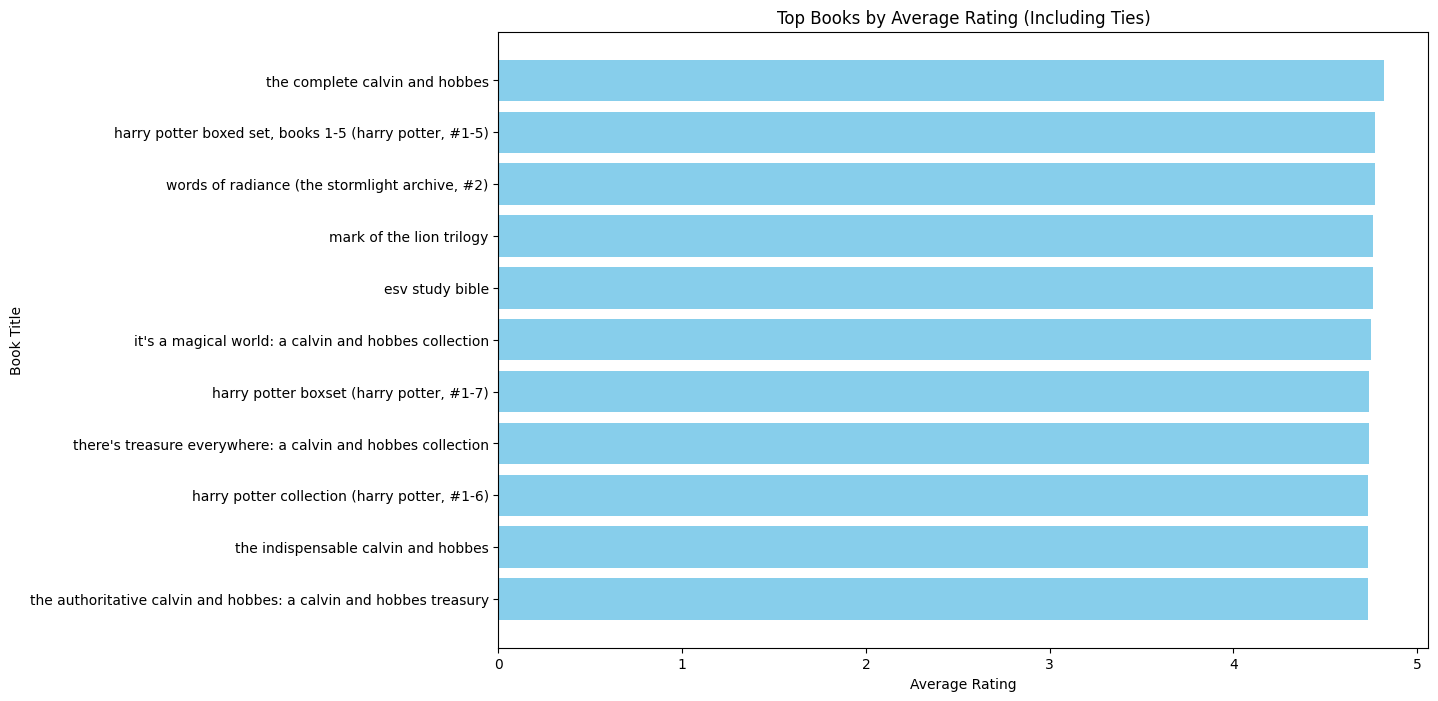

In [27]:
# Sort by average rating
sorted_ratings = books_df[['title', 'average_rating']].sort_values(by='average_rating', ascending=False)

# Find the rating value of the 10th highest rating (for handling ties)
tenth_highest_rating = sorted_ratings['average_rating'].iloc[9]

# Include all books with ratings greater than or equal to the 10th highest rating
top_ratings_with_ties = sorted_ratings[sorted_ratings['average_rating'] >= tenth_highest_rating]

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_ratings_with_ties['title'], top_ratings_with_ties['average_rating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.title('Top Books by Average Rating (Including Ties)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest ratings on top
plt.show()


#### Ratings count
The ratings count column contains the number of times a particular book was rated. Which books were rated the most time?

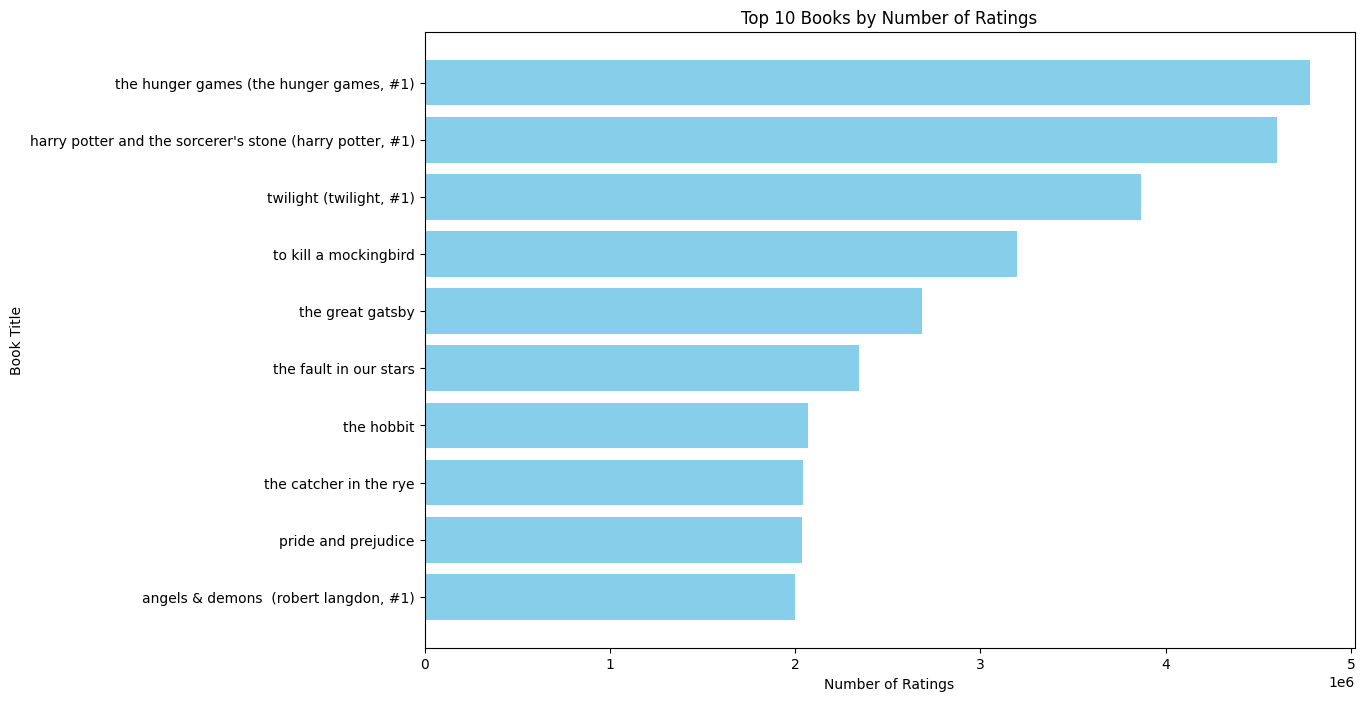

In [28]:
# Select the top 10 books by rating count
top_ratings_count = books_df[['title', 'ratings_count']].sort_values(by='ratings_count', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_ratings_count['title'], top_ratings_count['ratings_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.title('Top 10 Books by Number of Ratings')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest ratings on top
plt.show()


Hunger Games wins.

#### Distribution of ratings for books with the highest average ratings

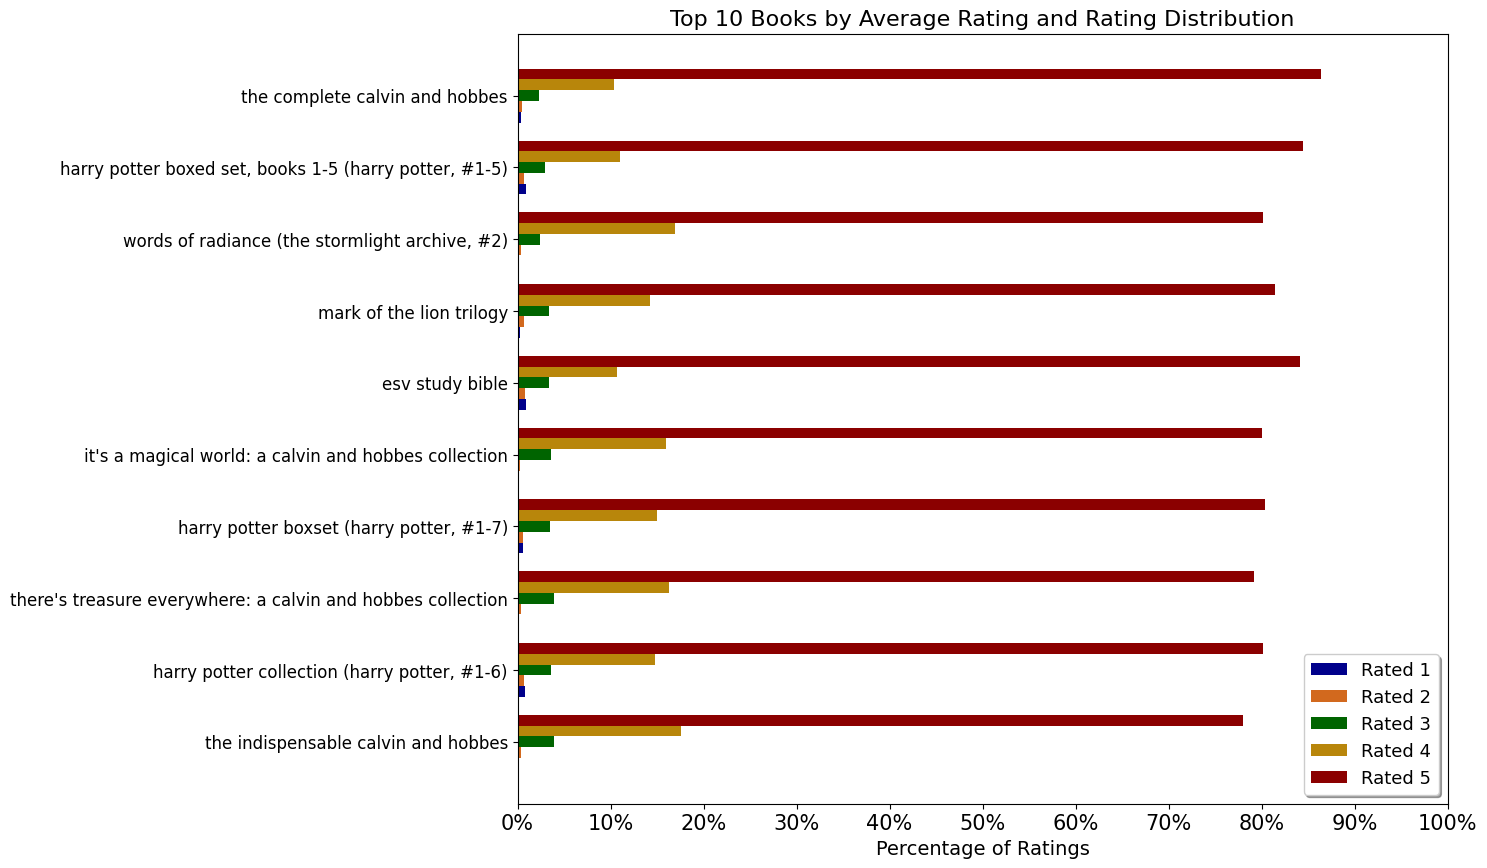

In [29]:
# Get the top 10 books by average rating
top_books_df = books_df[['title', 'average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']]
top_books_df = top_books_df.sort_values(by='average_rating', ascending=False).head(10)

# Extract the data for plotting
titles = top_books_df['title']
rating_1_percentages = (top_books_df['ratings_1'] / top_books_df[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)) * 100
rating_2_percentages = (top_books_df['ratings_2'] / top_books_df[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)) * 100
rating_3_percentages = (top_books_df['ratings_3'] / top_books_df[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)) * 100
rating_4_percentages = (top_books_df['ratings_4'] / top_books_df[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)) * 100
rating_5_percentages = (top_books_df['ratings_5'] / top_books_df[['ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sum(axis=1)) * 100

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(titles))  # the label locations
width = 0.15  # the width of the bars

ax.barh(x + width*2, rating_1_percentages, width, label='Rated 1', color='darkblue')
ax.barh(x + width, rating_2_percentages, width, label='Rated 2', color='chocolate')
ax.barh(x, rating_3_percentages, width, label='Rated 3', color='darkgreen')
ax.barh(x - width, rating_4_percentages, width, label='Rated 4', color='darkgoldenrod')
ax.barh(x - width*2, rating_5_percentages, width, label='Rated 5', color='darkred')

# Setting labels for bar chart
ax.set_xlabel('Percentage of Ratings', size=14)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 10)], fontdict={'fontsize': 15})
ax.set_yticks(x)
ax.set_yticklabels(titles, fontdict={'fontsize': 12})
ax.set_title('Top 10 Books by Average Rating and Rating Distribution', size=16)
ax.invert_yaxis()  # Invert y axis to have the highest ratings on top
ax.legend(shadow=0.4, prop={"size": 13})

# Adjusting and displaying the graph
fig.set_figheight(10)
fig.set_figwidth(12)
plt.show()

#### Distribution of ratings

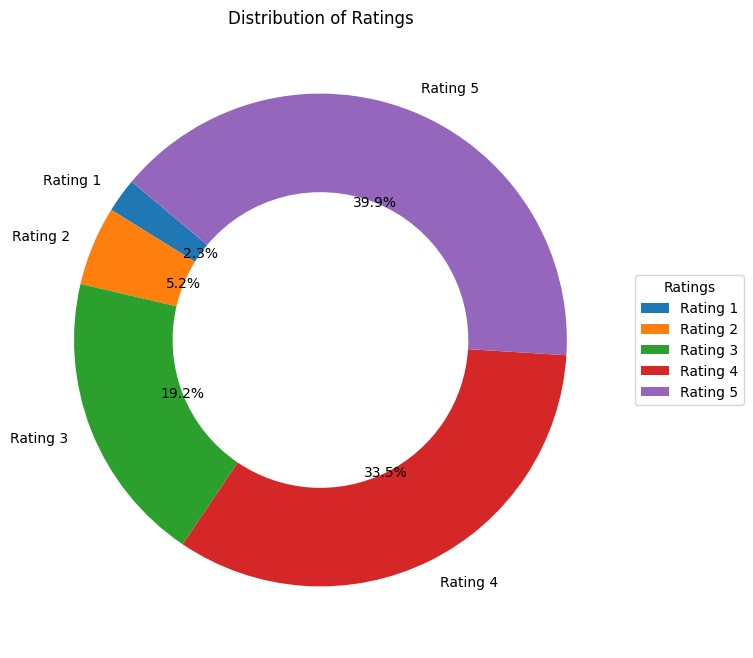

In [30]:
# Sum the counts for each rating
total_ratings = {
    'Rating 1': books_df['ratings_1'].sum(),
    'Rating 2': books_df['ratings_2'].sum(),
    'Rating 3': books_df['ratings_3'].sum(),
    'Rating 4': books_df['ratings_4'].sum(),
    'Rating 5': books_df['ratings_5'].sum()
}

# Data for pie chart
labels = list(total_ratings.keys())
sizes = list(total_ratings.values())
colors = plt.get_cmap('tab10').colors  # Choose a colormap with distinct colors

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))

# Add external legend
plt.legend(
    labels,
    title="Ratings",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Distribution of Ratings')
plt.show()


#### Top ten authors by book count

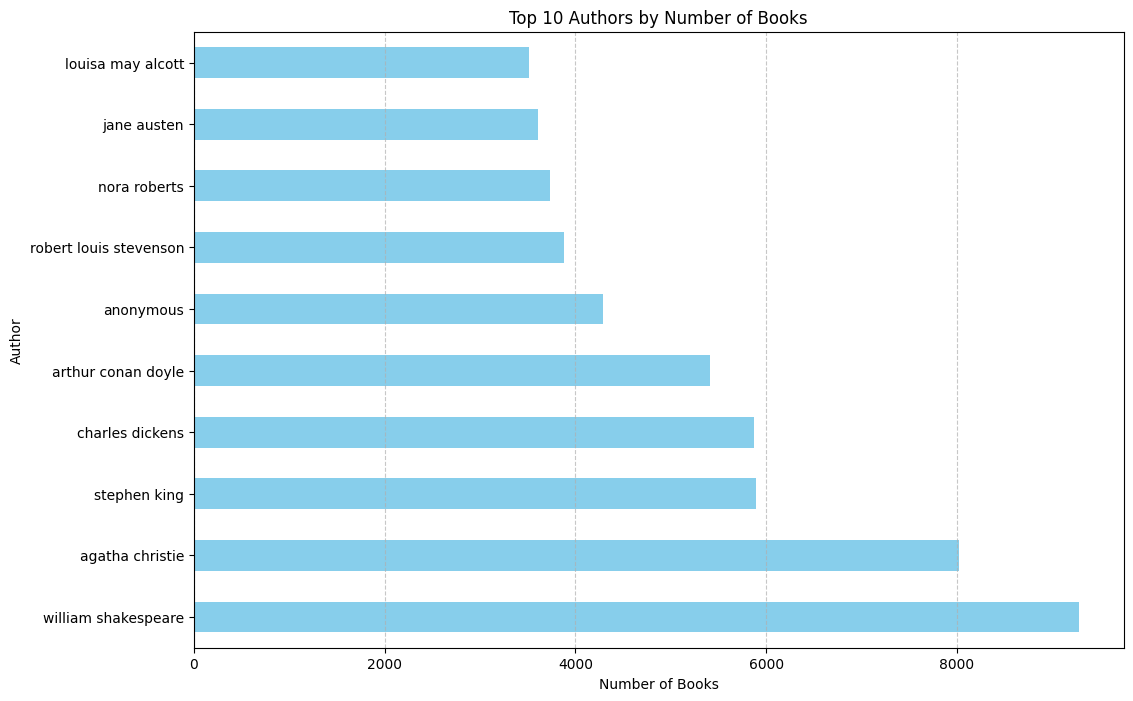

In [31]:
# Get the top 10 authors by book count
top_authors = books_df.groupby('authors')['books_count'].sum().nlargest(10)


# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
top_authors.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.title('Top 10 Authors by Number of Books')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


#### Distribution of books by language code

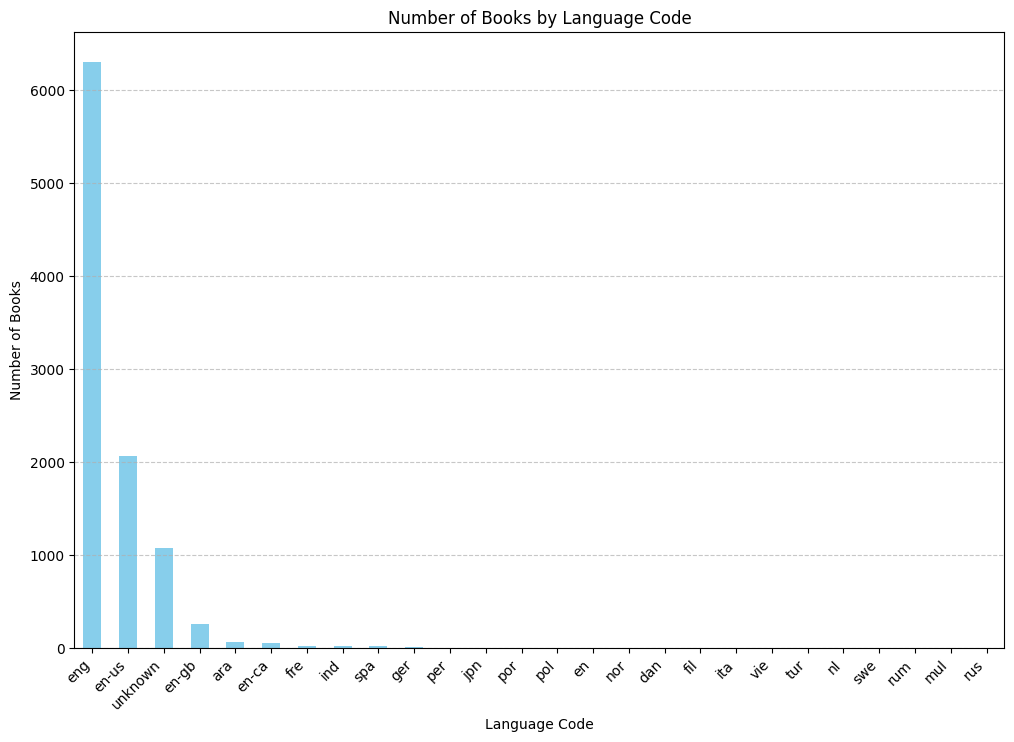

In [32]:
# Count the number of books for each language code
language_counts = books_df['language_code'].value_counts()

# Plot bar chart
plt.figure(figsize=(12, 8))
language_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Language Code')
plt.ylabel('Number of Books')
plt.title('Number of Books by Language Code')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Finding correlations

##### Rating count and average rating - Finding correlation between rating count and average rating
Does the most rated books have a high average rating?

In [33]:
# Calculate the Pearson correlation coefficient
correlation = books_df['ratings_count'].corr(books_df['average_rating'])

# Print the correlation coefficient
print(f"Pearson correlation between ratings_count and average_rating: {correlation}")

Pearson correlation between ratings_count and average_rating: 0.04580010196543927


#### Analysis
A correlation coefficient close to 0 (like 0.045) indicates that there is almost no linear relationship between ratings_count and average_rating. In other words, the number of ratings a book receives does not have a meaningful linear relationship with its average rating.

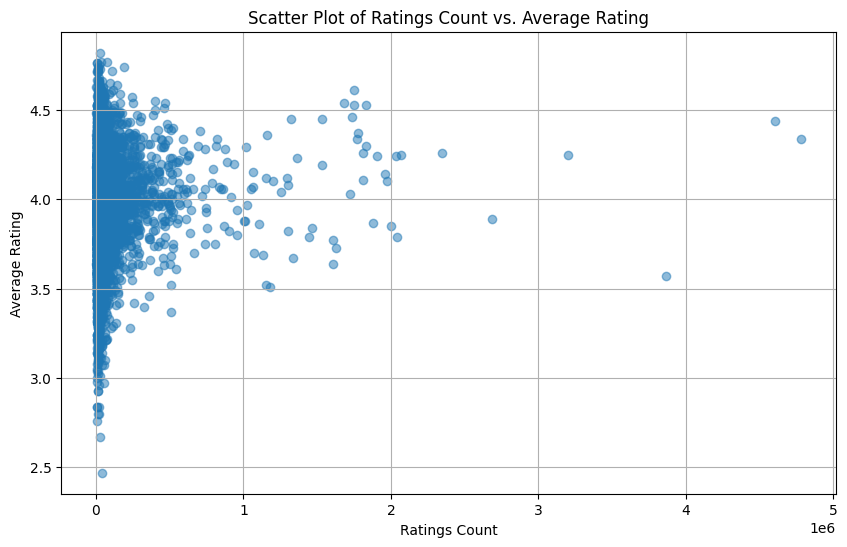

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(books_df['ratings_count'], books_df['average_rating'], alpha=0.5)
plt.xlabel('Ratings Count')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Ratings Count vs. Average Rating')
plt.grid(True)
plt.show()

##### Book count and average rating - Finding correlation between book count and average rating
Does the number of books associated with a particular title influences its average ratings?

In [35]:
# Calculate the Pearson correlation coefficient
correlation = books_df['books_count'].corr(books_df['average_rating'])

# Print the correlation coefficient
print(f"Pearson correlation between books_count and average_rating: {correlation}")

Pearson correlation between books_count and average_rating: -0.06859684564749079


#### Analysis
The value indicates a very weak negative relationship between books_count and average_rating. This means that there is a slight tendency for the average rating to decrease as the number of books increases, but the relationship is very weak and not significant.

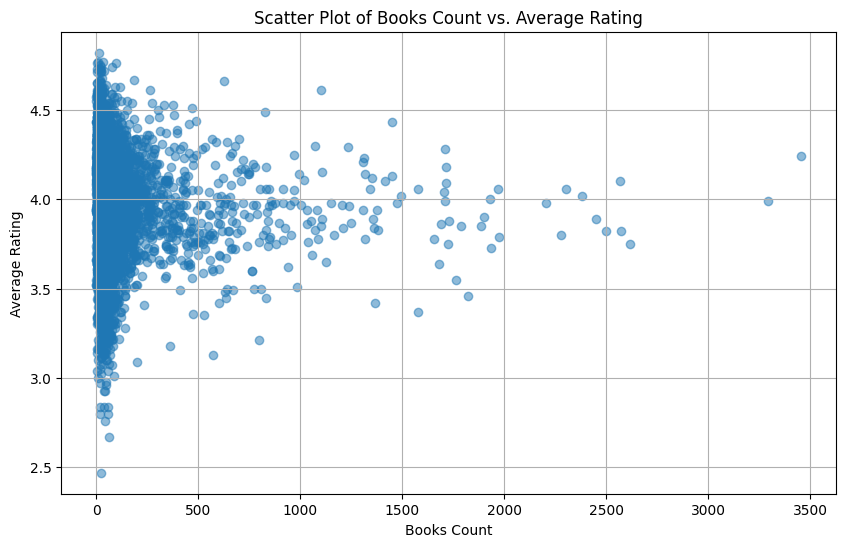

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(books_df['books_count'], books_df['average_rating'], alpha=0.5)
plt.xlabel('Books Count')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Books Count vs. Average Rating')
plt.grid(True)
plt.show()


##### Number of authors and average rating - Finding correlation between number of authors and average rating
Does the number of authors associated with a particular book influences its average rating?

In [37]:
# Calculate the number of authors for each book
books_df['number_of_authors'] = books_df['authors'].str.split(',').apply(lambda x: len(x))

# Calculate Pearson correlation
correlation = books_df['number_of_authors'].corr(books_df['average_rating'])
print(f'Pearson correlation between number of authors and average rating: {correlation}')

Pearson correlation between number of authors and average rating: 0.0749383840075884


#### Analysis
The value close to 0 indicates that there is a very weak linear relationship between the number of authors and the average rating. This means that the number of authors does not significantly influence the average rating of a book.


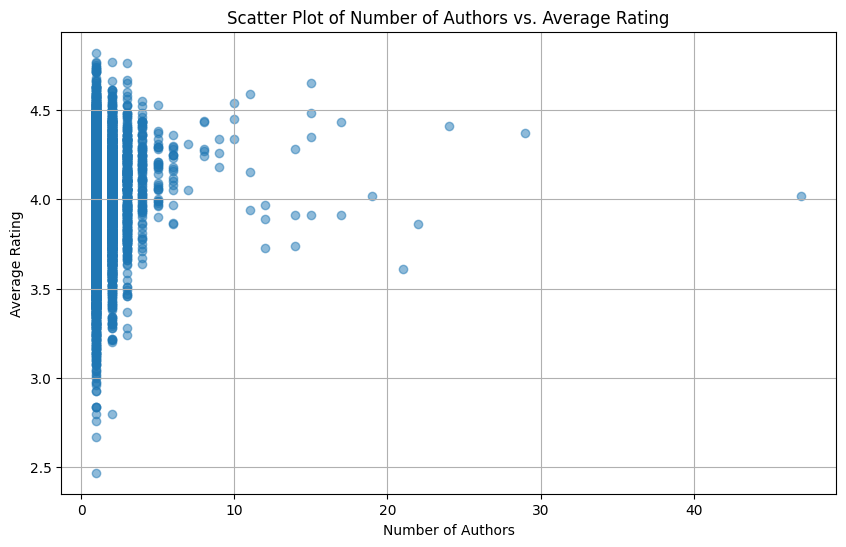

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(books_df['number_of_authors'], books_df['average_rating'], alpha=0.5)
plt.xlabel('Number of Authors')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Number of Authors vs. Average Rating')
plt.grid(True)
plt.show()


##### Series and average rating - Finding correlation between series and average ratings
Does being part of a series influence average rating? Are books in a series rated more highly on average than books that are not part of a series?

In [39]:
# Extract series information
books_df['series'] = books_df['title'].str.extract(r'\((.*?)\)')  # Extract everything within parentheses
books_df['series_number'] = books_df['series'].str.extract(r'#(\d+)').astype(float)  # Extract series number
books_df['series_name'] = books_df['series'].str.extract(r'([^,]+),').astype(str)  # Extract series name before comma

# Clean up NaN values 
books_df['series'].fillna('', inplace=True)
books_df['series_number'] = books_df['series_number'].fillna(0)
books_df['series_name'].fillna('')

# Create a binary column indicating if a book is part of a series
books_df['in_series'] = books_df['series'].apply(lambda x: 1 if x else 0)

# Calculate Pearson correlation between series membership and average rating
correlation_series = books_df['in_series'].corr(books_df['average_rating'])
print(f'Pearson correlation between series membership and average rating: {correlation_series}')

Pearson correlation between series membership and average rating: 0.22648060728138575


#### Analysis
The positive correlation of 0.225 indicates that, on average, books that are part of a series tend to have slightly higher average ratings. However, the correlation is not very strong, so while there is some positive relationship, it is not substantial.

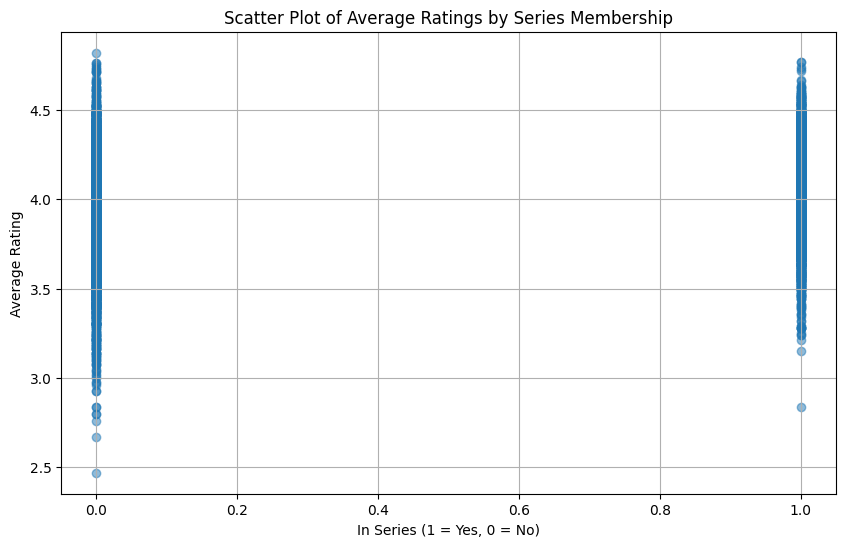

In [40]:
# Scatter plot of average ratings by series membership
plt.figure(figsize=(10, 6))
plt.scatter(books_df['in_series'], books_df['average_rating'], alpha=0.5)
plt.xlabel('In Series (1 = Yes, 0 = No)')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Average Ratings by Series Membership')
plt.grid(True)
plt.show()

### Exploring ratings dataset

##### Printing the first five ratings data

In [41]:
# Printing the ratings dataset
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


##### Showing count per rating - how many times was a particular rating given?

In [42]:
rating_counts = ratings_df['rating'].value_counts().sort_index()

print(rating_counts)


rating
1     124195
2     359257
3    1370916
4    2139018
5    1983093
Name: count, dtype: int64


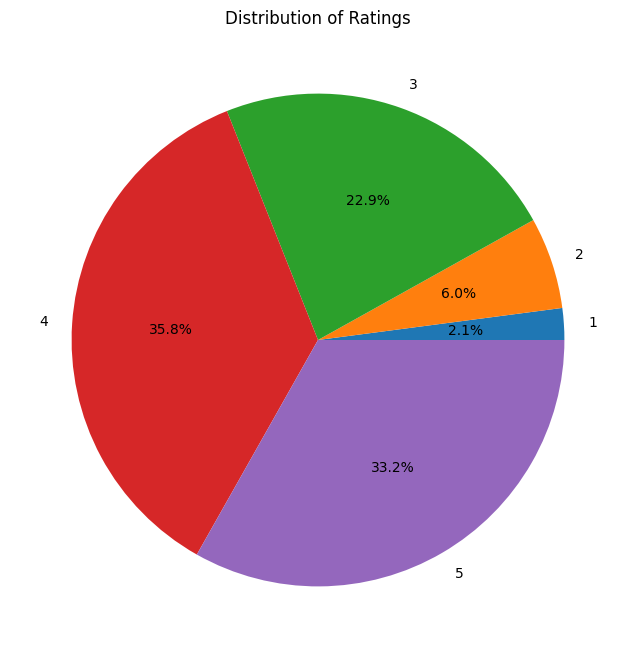

In [43]:
# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', colors=plt.get_cmap('tab10').colors)
plt.title('Distribution of Ratings')
plt.show()

##### Showing count per rating by book id - what are the rating distribution for each book?

In [44]:
# Group by book_id and rating, then count occurrences
rating_counts_by_book = ratings_df.groupby(['book_id', 'rating']).size().unstack(fill_value=0)

print(rating_counts_by_book.head())

rating      1     2     3     4      5
book_id                               
1         231   636  3013  7569  11357
2         207   553  2782  6122  12186
3        2698  2649  3901  3692   3991
4         164   548  2331  5839  10206
5         485  1401  4259  5725   4734


##### Analysis
Book with id 1:
- rating 1 - 231 times
- rating 2 - 636 times
- rating 3 - 3013 times
- rating 4 - 7569 times
- rating 5 - 11357 times

Book with id 1 was given rating of 4 or 5 far more times than it was given any other rating.

##### Showing count per rating by user id - what are the rating distribution for each user?

In [45]:
# Group by user_id and rating, then count occurrences
rating_counts_by_user = ratings_df.groupby(['user_id', 'rating']).size().unstack(fill_value=0)

print(rating_counts_by_user.head())

rating    1   2   3   4   5
user_id                    
1         3   8  45  39  22
2         0   2   9  14  40
3        47  24  18   1   1
4         6   5  34  58  31
5         0   3  16  55  26


#### Analysis
User with id 1 gave the ratings 1 to three different books, ratings 2 to eight different books, rating 3 to 45 different books, ratings 4 to 39 different books, rating 5 to 22 different books.

**Books which are rated by the most users**

In [46]:
# Group by book_id and count the number of users (ratings) for each book
user_counts_df = ratings_df.groupby('book_id').size().reset_index(name='num_users')

# Sort the DataFrame based on num_users in descending order
sorted_user_counts_df = user_counts_df.sort_values(by='num_users', ascending=False)

# Display the sorted DataFrame
print(sorted_user_counts_df.head())

   book_id  num_users
0        1      22806
1        2      21850
3        4      19088
2        3      16931
4        5      16604


**Users which have rated the most books**

In [47]:
# Group by user_id and count the number of books (ratings) for each user
book_counts_df = ratings_df.groupby('user_id').size().reset_index(name='num_books')

# Sort the DataFrame based on num_books in descending order
sorted_book_counts_df = book_counts_df.sort_values(by='num_books', ascending=False)

# Display the sorted DataFrame
print(sorted_book_counts_df.head())

       user_id  num_books
30943    30944        200
12873    12874        200
52035    52036        199
12380    12381        199
28157    28158        199


#### Persisting cleaned and condense datasets

In [50]:
# Columns to keep
columns_to_keep = ['title', 'authors', 'book_id']

# Drop all columns except the specified ones
books_df = books_df[columns_to_keep]

# Write cleaned DataFrame to csv
books_df.to_csv('books_cleaned.csv')
ratings_df.to_csv('ratings_cleaned.csv')


### WORD CLOUD

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Custom font file could not be loaded. Falling back to default font.


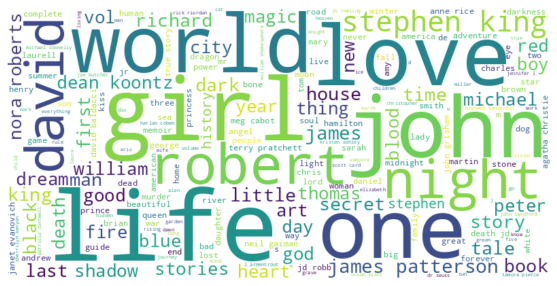

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
import requests
import os

def download_font(font_url, font_path):
    response = requests.get(font_url)
    response.raise_for_status()  # Ensure the download was successful
    with open(font_path, 'wb') as font_file:
        font_file.write(response.content)

def load_dataset(filepath):
    return pd.read_csv(filepath)

def preprocess_titles(df):
    df_titles_1 = df['title'].fillna('').apply(lambda x: re.sub(r'\(.*?\)', '', x).lower().strip())
    return df_titles_1

def preprocess_authors(df):
    df_authors = df['authors'].fillna('').apply(lambda text: re.sub(r'\s+', ' ', re.sub(r'\.', '', str(text).lower().strip())))
    return df_authors

def remove_stopwords(text_series):
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))

    cleaned_text = text_series.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return cleaned_text

def combine_columns(df, titles, authors):
    df['combined'] = titles + ' ' + authors
    return df


# Filepath for the font to be downloaded
font_url = 'https://github.com/google/fonts/raw/main/apache/roboto/Roboto-Regular.ttf'
font_path = 'Roboto-Regular.ttf'

# Download the font if it doesn't exist locally
if not os.path.exists(font_path):
    download_font(font_url, font_path)

filepath = 'books_cleaned.csv'
books_df = load_dataset(filepath)
df_titles_1 = preprocess_titles(books_df)
df_authors = preprocess_authors(books_df)
df_titles_2 = remove_stopwords(df_titles_1)
books_df = combine_columns(books_df, df_titles_2, df_authors)

# Combine all book titles and authors into a single string
text = " ".join(info for info in books_df['combined'])

# Attempt to generate the WordCloud with a built-in font if custom font fails
try:
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
except OSError:
    print("Custom font file could not be loaded. Falling back to default font.")
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate(text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for a cleaner look

# Save the WordCloud image to a file
wordcloud.to_file('wordcloud_books.png')

# Show the WordCloud
plt.show()